# Gemma 2 9B - Local YouTube Reflection Agent

Google recently released [Gemma 2](https://blog.google/technology/developers/google-gemma-2/), a new open source model in two forms, [27B](https://huggingface.co/google/gemma-2-27b) and [9B](https://huggingface.co/google/gemma-2-9b) parameters. The 9B model boasts impressive metrics, with claims of being the best <15B parameter model at the time of release. Technical report [available here](https://storage.googleapis.com/deepmind-media/gemma/gemma-2-report.pdf).

Let's put this to the test, and create a Local Gemma 2 9B Reflection Agent with a task that will focus on analysis, generation, and self correction to assess how well this model performs!

**The Gemma 2 9B YouTube Title Agent**
1. Analyzes a YouTuber's profile and videos
2. Generates a report about the YouTuber's style and approach
3. Applies these learnings to generate video titles on a new topic
4. Reflects at each step, either accepting the output or regenerating with additional instructions

![x](gemma29b_ytagent.png)

---

## Dependencies

To run Gemma 2 9b we'll be using [Ollama](https://ollama.com/) integrations with LangChain. For more details about getting up and running with Ollama, watch my [short video guide here](https://youtu.be/-lnR9oU0Jl8)!

Run `ollama pull gemma2` in your CLI to download Gemma2 9B before running these steps, additional Gemma configurations outlined on the [Ollama model page](https://ollama.com/library/gemma2).

In [1]:
# Imports
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
# Core LangChain
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain_community.chat_models import ChatOllama
# LangGraph
from langgraph.graph import END, StateGraph
from typing_extensions import TypedDict
# Additional stuff for loading and displaying output
from IPython.display import display, Markdown, Image
import json
import os

---
## Pulling Data from YouTube Data API

We'll be using Google's free [YouTube Data API](https://developers.google.com/youtube/v3) to pull relevant details about a channel, including channel statistics, recent videos, and video details.

Check out their [documentation here](https://developers.google.com/youtube/v3/getting-started) to see how you can set up an account and get an API key.

In [3]:
# Either set environment key or replace with your own key
# YT_API_KEY = ''

# Instantiate youtube object from API
youtube = build('youtube', 'v3', developerKey=YT_API_KEY)

# Main Function for Pulling & Formatting YT Data
def get_channel_info(channel_id):
    
    # Request to YT data API
    channel_response = youtube.channels().list(
        part='statistics,snippet,topicDetails,brandingSettings,contentDetails',
        id=channel_id
    ).execute()

    # Cutting up the response to process easier
    channel = channel_response['items'][0]
    statistics = channel['statistics']
    snippet = channel['snippet']
    topic_details = channel.get('topicDetails', {})
    branding = channel['brandingSettings']
    uploads_playlist_id = channel['contentDetails']['relatedPlaylists']['uploads']

    # Combining Relevant Info Into our own Dict
    channel_info = {
        "Channel Title": snippet['title'],
        "Description": snippet['description'],
        "Subscribers": statistics['subscriberCount'],
        "Total Views": statistics['viewCount'],
        "Total Videos": statistics['videoCount'],
        "Channel Topics": topic_details.get('topicCategories', []),
        "Keywords": branding['channel'].get('keywords', 'N/A'),
        "Recent Videos": []
    }

    # Get recent videos
    videos = get_recent_videos(uploads_playlist_id)

    # Format each video and attach to main channel_info dict
    for video in videos:
        video_info = {
            "Title": video['snippet']['title'],
            # "URL": f"https://www.youtube.com/watch?v={video['id']}",
            "Views": video['statistics']['viewCount'],
            "Likes": video['statistics']['likeCount'],
            "Comments": video['statistics']['commentCount'],
            # "Tags": video['snippet'].get('tags', [])
        }
        channel_info["Recent Videos"].append(video_info)

    return channel_info

# Function for grabbing a channel's uploads playlist (YT handles channel uploads as a playlist)
def get_recent_videos(playlist_id, max_results=10):
    
    # Get playlist ID of uploads
    playlist_response = youtube.playlistItems().list(
        part='snippet',
        playlistId=playlist_id,
        maxResults=max_results
    ).execute()

    # Get unique video IDs
    video_ids = [item['snippet']['resourceId']['videoId'] for item in playlist_response['items']]

    # Grab video details and attach IDs
    videos_response = youtube.videos().list(
        part='snippet,contentDetails,statistics,topicDetails',
        id=','.join(video_ids)
    ).execute()

    return videos_response['items']

# Test this out
# Replace with the channel ID you want to analyze
channel_info = get_channel_info("UCrPseYLGpNygVi34QpGNqpA")

# with open("gemma2/channel_info.json", "w") as json_file:
#             json.dump(channel_info, json_file, indent=4)

# with open("gemma2/channel_info.json", "r") as json_file:
#     channel_info = json.load(json_file)

channel_info

{'Channel Title': 'Ludwig',
 'Description': 'if ur reading this please click subscribe :)\n',
 'Subscribers': '5910000',
 'Total Views': '2289396167',
 'Total Videos': '1974',
 'Channel Topics': ['https://en.wikipedia.org/wiki/Action_game',
  'https://en.wikipedia.org/wiki/Role-playing_video_game',
  'https://en.wikipedia.org/wiki/Video_game_culture',
  'https://en.wikipedia.org/wiki/Action-adventure_game'],
 'Keywords': 'Ludwig Ahgren',
 'Recent Videos': [{'Title': 'MOGUL MONEY LIVE!',
   'Views': '1494900',
   'Likes': '63921',
   'Comments': '1093'},
  {'Title': '🔴 DAY 1 OF BEING ON TIME EVERYDAY IN JULY | VALO IN-HOUSE with friends :)',
   'Views': '162479',
   'Likes': '3103',
   'Comments': '53'},
  {'Title': "I'm NOT the World's Fastest Masher",
   'Views': '654051',
   'Likes': '50837',
   'Comments': '412'},
  {'Title': '🔴 NEW MR BEAST VIDEO | PROVING I AM BETTER AT VIDEO GAMES THAN CHAT',
   'Views': '199111',
   'Likes': '4202',
   'Comments': '73'},
  {'Title': 'Can I Beat 

---
# Gemma 2 Prompts

Now we'll define the prompts that Gemma 2 will process at each stage, one thing to note is that Gemma 2 is trained with special tokens, so prompts need to follow a specific format so that it doesn't continue endlessly generating, as it expects the prompt in a specific format. Here are the tables from the technical report showing how this is set up:

<img src="gemma_tokens.png" width="800" style="border: 1px solid black;">

We'll be using LangChain's framework and [Ollama integration](https://python.langchain.com/v0.2/docs/integrations/chat/ollama/) to set this up.

In [4]:
# Defining LLM Objects
local_llm = 'gemma2'
# Regular model for responses
gemma2 = ChatOllama(model=local_llm, temperature=0.7)
# JSON mode for structered responses
gemma2_json = ChatOllama(model=local_llm, format='json', temperature=0.7)

### Report Generation Prompt

In [5]:
# Generation Prompt
analysis_prompt = PromptTemplate(
    template="""
    <bos>
    
    <start_of_turn>user
    
    You are an AI assistant for YouTube Analysis Tasks, that reports the main findings of a YouTube data pull. 
    Your main goal is to analyze how the account formats and creates their youtube titles.
    Carefully analyze the YouTube titles and any other useful information, and create a short report that covers
    everything one may want to know to imitate their success, be as specific as possible with your analysis.
    
    --------------
    Additional Instructions (if any): {reflection}
    --------------
    Pulled YouTube Data: {data}
    --------------
    Begin your response<end_of_turn>
    
    <start_of_turn>model""",
    input_variables=["data", "reflection"],
)

# Chain
analysis_chain = analysis_prompt | gemma2 | StrOutputParser()

# Test Run
report = analysis_chain.invoke({"data": channel_info, "reflection": ""})
display(Markdown(report))

## Ludwig YouTube Title Analysis Report

**Channel Overview:** Ludwig is a popular gaming and variety streamer with a subscriber count of 5.91 million and over 2.29 billion total views. His channel focuses on action games, role-playing games, and video game culture.

**Title Analysis:**

Ludwig's YouTube titles are designed to be **click-baity, intriguing, and action-oriented**. They frequently employ the following strategies:

* **Exclamation Points:** Titles often end with exclamation points to create a sense of excitement and urgency. Examples: "MOGUL MONEY LIVE!", "🔴 DAY 1 OF BEING ON TIME EVERYDAY IN JULY | VALO IN-HOUSE with friends :)"
* **Direct Address:** Ludwig directly addresses his viewers in many titles, fostering a sense of community and personal connection. Examples: "🔴 NEW MR BEAST VIDEO | PROVING I AM BETTER AT VIDEO GAMES THAN CHAT", "Can I Beat a Child Prodigy at Ping Pong? | Unpaid Intern"
* **Intriguing Questions:** Titles often pose questions that pique viewer curiosity and encourage them to click for answers. Examples: "I'm NOT the World's Fastest Masher", "Can I Score Against a D1 Basketball Player?"
* **Humor and Relatability:** Ludwig incorporates humor and relatable situations into his titles to make them more appealing. Examples: "I Let My Chat Decorate My Room. $15,000 Mistake.", "I got roasted so hard I changed my name"
* **Keywords:** Titles strategically incorporate relevant keywords related to gaming, challenges, and popular personalities like MrBeast.

**Additional Observations:**

* **Live Streams:** A significant portion of Ludwig's titles indicate live streams, highlighting his active engagement with his audience.
* **Variety Content:** While gaming is a core focus, Ludwig's titles also showcase his diverse content, including challenges, collaborations, and personal experiences.
* **Branding:** The consistent use of emojis and the "🔴" symbol adds a recognizable brand element to his titles.

**Imitation Tips:**

* **Be Click-Baity:** Craft titles that are attention-grabbing and encourage clicks.
* **Engage Your Audience:** Directly address your viewers and create a sense of community.
* **Pose Intriguing Questions:** Spark curiosity and encourage viewers to find out more.
* **Inject Humor and Relatability:** Make your titles fun and relatable to your target audience.
* **Use Keywords Strategically:** Incorporate relevant keywords to improve discoverability.
* **Brand Consistency:** Develop a recognizable style and branding for your titles.



By analyzing and applying these strategies, aspiring YouTubers can learn from Ludwig's successful approach to title creation and increase their chances of attracting viewers and building a loyal fanbase.

### Title Generation Prompt

In [6]:
# Reccomendation Prompt
reccomendation_prompt = PromptTemplate(
    template="""
    <bos>
    
    <start_of_turn>user
    
    You are an AI assistant for applying YouTube Analysis reports to create new YouTube Titles, 
    Your coworker has created a report that analyzes and creates suggestions for creating new YouTube titles. 
    Your goal now is to apply these learnings to craft potential youtube titles about a new topic.
    Carefully analyze the report and apply the learned techniques to generate 5 new titles on the new topic.
    Ensure that you are directly applying the techniques outlined in the data report to your generation.
    Add a short explanation as to how each generated title follows the report findings. List in markdown format.
    --------------
    Additional Instructions (if any): {reflection}
    --------------
    YouTube Data Report: {report}
    --------------
    New Topic: {new_topic}
    --------------
    
    If additional instructions are present, then this is a revision step. 
    You are to follow the instructions to improve upon your prior generation that will be listed with the additional instructions.
    
    Begin your response<end_of_turn>
    <start_of_turn>model""",
    input_variables=["report", "new_topic", "reflection"],
)

# Chain
reccomendation_chain = reccomendation_prompt | gemma2 | StrOutputParser()

# # Test Run
topic = "Building a YouTube title generator AI agent with reflection using the new LLM from google, Gemma 2 9b"
reccomendation = reccomendation_chain.invoke({"report": report, "new_topic": topic, "reflection": ""})
display(Markdown(reccomendation))

Here are 5 potential YouTube titles about building a YouTube title generator AI agent with reflection using Gemma 2 9b, applying the strategies from Ludwig's report:

1. **🔴 Can I Build a YouTube Title Generator with Gemma 2 9B? (AI vs. Humans!)** 
    * **Explanation:** This title uses the "🔴" symbol for live stream indication, directly addresses the audience, and poses a question to spark curiosity. It also highlights the AI vs. human element for added intrigue.

2. **Gemma 2 9B: My AI Learns to Write Click-Baity YouTube Titles! (Mind-Blowing Results)**
    * **Explanation:** This title uses "click-baity" as a keyword, promises "mind-blowing results," and emphasizes the AI's learning process, appealing to viewers interested in AI development.

3. **I Trained an AI to Write YouTube Titles... and It's BETTER Than Me! (Gemma 2 9B Challenge)**
    * **Explanation:** This title uses humor and a bold claim ("better than me") to grab attention. It also incorporates the "challenge" element popular in gaming and tech content.

4. **YouTube Title Secrets REVEALED! Gemma 2 9B Shows How It's Done (Data-Driven AI)**
    * **Explanation:** This title promises to reveal secrets, uses the keyword "YouTube Title Secrets," and emphasizes the data-driven approach of the AI, appealing to viewers seeking practical knowledge.

5. **Building a YouTube Title Generator with Gemma 2 9B: A Step-by-Step Guide (Reflection & Analysis)**
    * **Explanation:** This title is more informative and targets viewers seeking a tutorial. It clearly outlines the project and includes keywords like "step-by-step guide," "reflection," and "analysis."





### Reflection Step Prompt

In [7]:
# Reflection Prompt
reflection_prompt = PromptTemplate(
    template="""
    <bos>
    
    <start_of_turn>user

    You are an AI assistant verifying and validating the current analysis workflow to ensure that ideas are applied and unique.
    The current project is to analyze a YouTube channel, create a report about the video titles, and apply the learnings to create titles for a new topic.
    Your task is to verify that these steps have been completed and are of high quality. 
    Observe what's been written, and either approve or deny. Provide any additional instructions for what may be necessary to fix if denied.

    Work to analyze from the {task} step: 
    ---------------
    {candidate}
    ---------------
    Context (if any) for what generation is based on:
    ---------------
    {context}
    ---------------
    
    Return your answer in JSON format, with no preamble or explanation, as such: "verdict": "approve/deny", "instructions": "further instructions"

    Begin your response<end_of_turn>
    <start_of_turn>model""",
    input_variables=["task", "candidate", "context"],
)

# Chain
reflection_chain = reflection_prompt | gemma2_json | JsonOutputParser()

# Test Run
reflection = reflection_chain.invoke({"task": "title generation", "candidate": reccomendation, "context": report})
reflection

{'verdict': 'approve', 'instructions': ''}

---
# LangGraph Setup

To automate our LLM operations and create this *agentic* workflow, we'll be using [LangGraph](https://langchain-ai.github.io/langgraph/)! 

From their website, LangGraph is *"a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Compared to other LLM frameworks, it offers these core benefits: cycles, controllability, and persistence. LangGraph allows you to define flows that involve cycles, essential for most agentic architectures, differentiating it from DAG-based solutions"*

In simpler terms, LangGraph let's us pass all data along a set graph (see diagram at the top of the notebook), where we can use, update, or change our pathing depending on the saved values in that data. This might be kinda confusing, but seeing how this works in practice below should help clear things up!

## Defining the Main State

The state is the "container" that will hold all of our necessary data as it goes along the whole agentic journey, this one below has 6 values that will be pulled or updated at different stages:
1. **task** - tracks the current task that is happening
2. **new_topic** - holds what our new topic for generating titles will be
3. **youtube_data** - holds all of the information that we pulled from the YouTube data API
4. **generated_report** - holds the generated report from Gemma after it is generated
5. **generated_titles** - holds the generated titles from Gemma after they are generated
6. **reflection** - Holds the dictionary from the reflection step that contains the verdict and any additional instructions

These fields will be pulled from for processing and updated dynamically at each step along the way

In [8]:
# Main State
class GraphState(TypedDict):
    """
    Represents the state of our YouTube Agent graph.

    Attributes:
        task: Current task being executed
        new_topic: Topic for generation to be applied to
        youtube_data: Pulled youtube data from API
        generated_report: LLM generated Analysis Report
        generated_titles: LLM generated Titles
        reflection: LLM reflection step
    """
    task : str
    new_topic: str
    youtube_data: str
    generated_report: str
    generated_titles: str
    reflection: dict

## Defining the Nodes

The nodes are the preset steps at which our above state will be passed through and undergo some sort of processing + update. We define four below:

### Node 1: Getting YouTube Channel Details

This will be our entry point (defined later), where we will ask for input on a channel ID for analysis, and a new topic to apply our research to.

It takes these two inputs, calls the channel info function, and returns the data back to the state, updating the **youtube_data**, and **new_topic** fields. 

Additionally, we manually update the current **task** field to *initiate*, and input a blank placeholder into the **reflection** field, so that before we do any reflection our initial steps will not throw any errors due to missing values.

In [9]:
# Node - Getting YouTube Channel Details

def get_yt_details(state):
    """
    Instantiate's graph and grabs channel report from YouTube API and append to graph state.
    
    Returns:
        Instantiates blank reflection for initial run,
        Appends pulled youtube data to youtube_data,
        Appends new topic to new_topic,
        Logs current task.
    """

    # Instantiate the reflection as blank
    # Handles first run, where report and title generation prompt expect some value for additional instructions if necessary
    reflection = {'verdict': '', 'instructions': ''}
    
    channel_id = input("Input Channel ID: ")
    new_topic = input("What topic are you applying this analysis to? ")
    channel_info = get_channel_info(channel_id)

    print("Channel & Video Details Pulled")
    
    return {"youtube_data": channel_info, "reflection": reflection, "new_topic": new_topic, "task": "initiate"}

### Node 2: Generating a Report From the YouTube Data

This will take in the state, and grab the YouTube data that we just acquired our previous API call from the **youtube_data** field, and run it through our analysis report chain. The generated report will then populate the **generated_report** field in our state.

Additionally, we have some handling for the reflection instructions if it has been kicked back to this state, grabbing the instructions from the **reflection** field in our state and passing them along to the prompt.

In [10]:
# Node - Generate a Report From YouTube Data

def gen_report(state):
    """
    Generate the analysis report based on the YouTube channel details.

    Returns:
        Appends generated report to generated_report in the graph state,
        Logs current task.
    """
    
    youtube_data = state["youtube_data"]
    reflection_instructions = state["reflection"]['instructions']
    
    inputs = {"data": youtube_data, "reflection": reflection_instructions}
    report = analysis_chain.invoke(inputs)

    print("Report Generated")
    
    return {"generated_report": report, "task": "gen_report"}

### Node 3: Generating Titles With the Report

This will then handle the title generation step, grabbing the report from the **generated_report** field and the topic from the **new_topic** field, and pass them through the reccomendation chain to generate new titles. This will return the title generation to the **generated_titles** field in our state!

Similar to the last node, we also pull the reflection instructions from the **reflection** field to handle if there are any tweaks needed if it gets kicked back to this step from reflection, and to make sure that we're not blindly generating with no ground reference is the reflection denies our pass, we insert the prior generated titles along with the instructions.

In [11]:
# Node - Generate Potential Titles 

def gen_titles(state):
    """
    Generate potential titles based on report analysis.

    Returns:
        Appends generated titles to generated_report in the graph state,
        Logs current task.
    """
    
    generated_report = state["generated_report"]

    if state['generated_titles'] is not None:
        reflection_instructions = f"{state['reflection']['instructions']}\nPrior generated titles: {state['generated_titles']}"
    else:
        reflection_instructions = state['reflection']['instructions']

    new_topic = state["new_topic"]
    
    inputs = {"report": generated_report, "new_topic": new_topic, "reflection": reflection_instructions}
    generated_titles = reccomendation_chain.invoke(inputs)

    print("Titles Generated")
    
    return {"generated_titles": generated_titles, "task": "gen_titles"}

### Node 4: Reflection 🤔

This node will handle both of our reflection steps, taking in the current **task** from the state task field to determine whether we're reflecting on report generation or title generation. Depending on which one it is, either the report from the **generated_report** field of the titles from the **generated_titles** field will be grabbed and passed through the reflection chain. 

As we defined in our prompt, the reflection chain will return a dictionary of a verdict and any additional instructions, updating the **reflection** field of our state.

In [12]:
# Node - Reflections 

def reflect(state):
    """
    Reflection and verification of different steps during the process.

    Returns:
        Verdict of whether generation was adequate,
        Additional instructions,
        Logs current task.
    """

    task = state["task"]
    topic = state["new_topic"]

    if task == "gen_report":
        generated_report = state["generated_report"]
        inputs = {"task": "YouTube Report Generation", "candidate": generated_report, "context": "None"}
        reflection = reflection_chain.invoke(inputs)
    elif task == "gen_titles":
        generated_titles = state["generated_titles"]
        context = state["generated_report"]
        inputs = {"task": f"Applying YouTube report findings to Title Generation about {topic}", "candidate": generated_titles, "context": context}
        reflection = reflection_chain.invoke(inputs)

    print(f"Reflected on {task}, verdict: {reflection['verdict']}, additional instructions: {reflection['instructions']}")
    
    return {"reflection": reflection}

### Reflection Logic - Conditional Edge

One of the quirks of LangGraph is that the routing logic when we get to actually building the graph cannot be solely determined from a node output, it must have an intermediary function that handles the logic to return which node to head to next. 

This will make more sense when we actually build the graph itself, but this below function will handle whether to route our reflection output back to the report generation step or the title generation step.

It takes in the verdict from the **reflection** field of the state, and the task from the **task** field of the state (either report generation, or title generation), and will either pass that the report has been approved or denied, or that the titles have been approved or denied. The routing is then handled from this output as a conditional edge in the graph building stage below.

In [13]:
# Conditional Edge - Routing Based on Reflection

def verdict_logic(state):
    """
    route question either next or back based on reflection.

    Returns:
        Next node to call
    """

    verdict = state['reflection']['verdict']
    task = state["task"]
    
    if task == "gen_report":
        if verdict == "approve":
            return "approve_report"
        elif verdict == "deny":
            return "deny_report"
            
    elif task == "gen_titles":
        if verdict == "approve":
            return "approve_titles"
        elif verdict == "deny":
            return "deny_titles"

---
# Putting the LangGraph Graph Together

Now that we have our nodes defined, we have to build the graph up!

**This involves:**
1. Adding the nodes to the workflow
2. Defining the entry point
3. Connecting the nodes together
   1. Either through direct connections - edges
   2. Or through seperate logic - conditional edges
4. Compiling the graph into a final agent!

We want the flow do go something like: 

Grab youtube details -> generate a report -> Reflect on report: If denied, back to generate, if approved -> generate titles with report -> reflect on generated titles: If denied, back to generate, if approved -> end and display to the user.

In [14]:
# Creating a helper object to build the graph
workflow = StateGraph(GraphState)

# Adding all of the nodes to the graph, and which node function they correspond to
workflow.add_node("get_yt_details", get_yt_details)
workflow.add_node("gen_report", gen_report)
workflow.add_node("gen_titles", gen_titles)
workflow.add_node("reflect", reflect)

# Defining our starting point
workflow.set_entry_point("get_yt_details")

# Connecting our Nodes together
workflow.add_edge("get_yt_details", "gen_report")
workflow.add_edge("gen_report", "reflect")
workflow.add_edge("gen_titles", "reflect")

# Using the verdict_logic function to handle conditional connections from the reflection step
workflow.add_conditional_edges("reflect", 
                             verdict_logic,
                             {
                                 "approve_report": "gen_titles",
                                 "deny_report": "gen_report",
                                 "approve_titles": END,
                                 "deny_titles": "gen_titles",
                             })

# Putting it all together!
yt_agent = workflow.compile()

### Different Visualization

We can use IPython to generate a mermaid chart from the graph, and see exactly what's going on behind the scenes here

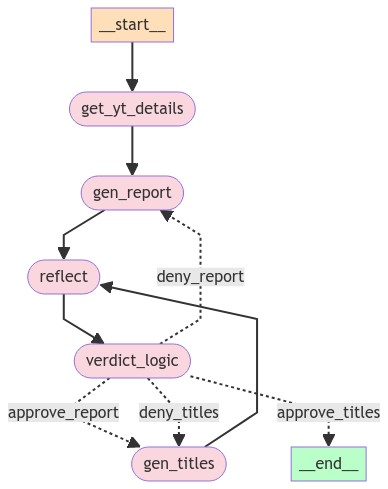

In [15]:
# Mermaid chart
display(Image(yt_agent.get_graph(xray=True).draw_mermaid_png()))

---
# Running the Agent

Now that it's all compiled and together, time to test it out!

As our YouTube API function takes the channel ID (found in channel about section), here are some starting examples I gathered:

<!DOCTYPE html>
<html>
<head>
    <style>
        .left-align {
            float: left;
        }
        table {
            border-collapse: collapse;
            width: 50%;
        }
        th, td {
            border: 1px solid black;
            padding: 8px;
            text-align: left;
        }
        th {
            background-color: #f2f2f2;
        }
    </style>
</head>
<body>

<div class="left-align">
    <table>
        <tr>
            <th>YouTuber</th>
            <th>Channel ID</th>
        </tr>
        <tr>
            <td><a href="https://www.youtube.com/channel/UCy6rH4hKHMLdd5s-FUrto7Q" target="_blank">Adam Lucek</a></td>
            <td>UCy6rH4hKHMLdd5s-FUrto7Q</td>
        </tr>
        <tr>
            <td><a href="https://www.youtube.com/channel/UCrPseYLGpNygVi34QpGNqpA" target="_blank">Ludwig Ahgren</a></td>
            <td>UCrPseYLGpNygVi34QpGNqpA</td>
        </tr>
        <tr>
            <td><a href="https://www.youtube.com/channel/UCX6OQ3DkcsbYNE6H8uQQuVA" target="_blank">Mr Beast</a></td>
            <td>UCX6OQ3DkcsbYNE6H8uQQuVA</td>
        </tr>
        <tr>
            <td><a href="https://www.youtube.com/channel/UCHnyfMqiRRG1u-2MsSQLbXA" target="_blank">Veritasium</a></td>
            <td>UCHnyfMqiRRG1u-2MsSQLbXA</td>
        </tr>
        <tr>
            <td><a href="https://www.youtube.com/channel/UCXuqSBlHAE6Xw-yeJA0Tunw" target="_blank">Linus Tech Tips</a></td>
            <td>UCXuqSBlHAE6Xw-yeJA0Tunw</td>
        </tr>
        <tr>
            <td><a href="https://www.youtube.com/channel/UCsBjURrPoezykLs9EqgamOA" target="_blank">Fireship</a></td>
            <td>UCsBjURrPoezykLs9EqgamOA</td>
        </tr>
        <tr>
            <td><a href="https://www.youtube.com/channel/UCBJycsmduvYEL83R_U4JriQ" target="_blank">MKBHD</a></td>
            <td>UCBJycsmduvYEL83R_U4JriQ</td>
        </tr>
        <tr>
            <td><a href="https://www.youtube.com/channel/UCJHA_jMfCvEnv-3kRjTCQXw" target="_blank">Babish Culinary Universe</a></td>
            <td>UCJHA_jMfCvEnv-3kRjTCQXw</td>
        </tr>
        <tr>
            <td><a href="https://www.youtube.com/channel/UCiDJtJKMICpb9B1qf7qjEOA" target="_blank">Tested</a></td>
            <td>UCiDJtJKMICpb9B1qf7qjEOA</td>
        </tr>
        <tr>
            <td><a href="https://www.youtube.com/channel/UC-lHJZR3Gqxm24_Vd_AJ5Yw" target="_blank">PewDiePie</a></td>
            <td>UC-lHJZR3Gqxm24_Vd_AJ5Yw</td>
        </tr>
    </table>
</div>

</body>
</html>


### Optionally Use LangSmith for Tracing

Since we're using LangChain's offerings, they integrate very well with the [LangSmith](https://www.langchain.com/langsmith) tracing service. Set your LangChain API, Tracing, and Project environment variables to enable

In [17]:
# Optional LangSmith Tracing
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ["LANGCHAIN_PROJECT"] = "Gemma 2 - YT Agent"

### Main Script

In [18]:
# New Topic Idea: Building a YouTube title generator AI agent with reflection using the new LLM from google, Gemma 2 9b

output = yt_agent.invoke({})

# Pretty Display of Generated Messages
display(Markdown("# Gemma 2 9B YouTube Title Agent"))
display(Markdown("---"))
display(Markdown(output["generated_report"]))
display(Markdown("---"))
display(Markdown("## Generated Titles"))
display(Markdown(output["generated_titles"]))

Input Channel ID:  UCXuqSBlHAE6Xw-yeJA0Tunw
What topic are you applying this analysis to?  Building a YouTube title generator AI agent with reflection using the new LLM from google, Gemma 2 9b


Channel & Video Details Pulled
Report Generated
Reflected on gen_report, verdict: approve, additional instructions: 
Titles Generated
Reflected on gen_titles, verdict: approve, additional instructions: 


# Gemma 2 9B YouTube Title Agent

---

## Linus Tech Tips YouTube Title Analysis Report 

**Objective:**  To analyze the YouTube title formatting and content used by Linus Tech Tips to understand their success and provide actionable insights for imitation.

**Data Source:**  Provided YouTube data for Linus Tech Tips, including recent video titles, views, likes, and comments.

**Key Findings:**

* **Intrigue & Clickbait:** Linus Tech Tips excels at crafting titles that pique curiosity and encourage clicks. They often use phrases like:
    * "The Truth about..."
    * "It's Time to End..."
    * "I Bought..."
    * "Why did you make me build this?"
    * "Is Future Proofing Your PC Build Stupid?"
* **Bold Statements:**  They aren't afraid to make strong claims or take controversial stances, which can generate discussion and engagement. Examples include "I Bought 25 Million Computer Viruses" and "My Wifi is Better than Yours."
* **Humor & Personality:** Many titles incorporate humor or playful language, reflecting the channel's lighthearted and entertaining tone. "First Person That Says Hi Gets Free PC" and "Tech Experts React to Bad & Great Tech in TV Crime Shows ep2" are examples.
* **Keyword Relevance:** Titles consistently incorporate relevant keywords related to technology, gaming, and hardware, likely aiding in search engine optimization (SEO). Examples include "Unboxing Review Computer Hardware Motherboard Intel AMD NVIDIA gaming" mentioned in the data.
* **Call to Action (Implicit):** While not always explicit, titles often imply a call to action, encouraging viewers to watch the video to learn more or discover the outcome.

**Recommendations for Imitation:**

1. **Craft Intriguing & Clickbaity Titles:**  Start with a hook that immediately grabs attention and makes viewers want to know more.
2. **Don't Be Afraid to Be Bold:** Take a stance, make a claim, or present a unique perspective to stand out from the crowd.
3. **Inject Humor & Personality:**  Let your unique voice shine through in your titles to create a more engaging and memorable experience.
4. **Optimize for Keywords:**  Research relevant keywords in your niche and incorporate them naturally into your titles.
5. **Create a Sense of Urgency or Curiosity:**  Suggest that viewers will miss out on something valuable if they don't watch the video.


**Conclusion:**

Linus Tech Tips' success is largely due to their ability to craft compelling YouTube titles that are both informative and engaging. By following the recommendations outlined in this report, creators can learn from their strategies and improve their own channel performance.




---

## Generated Titles

Here are 5 potential YouTube titles about building a YouTube title generator AI agent with reflection using Gemma 2 9b, applying the techniques from the Linus Tech Tips report:

1. **"I Built a YouTube Title Generator AI... and It's INSANE!"**  
    * **Explanation:** This title uses the "I Built..." hook, promises an insane result, and implies a sense of wonder and excitement, encouraging clicks.

2. **"Gemma 2 9b: Can This AI Write YouTube Titles BETTER Than Humans?"** 
    * **Explanation:** This title poses a bold question, sparking curiosity and debate. It also incorporates the relevant keyword "Gemma 2 9b" and hints at a comparison, creating intrigue.

3. **"YouTube Title Secrets REVEALED! My AI Learns to Write Clickbait Like a PRO"**
    * **Explanation:** This title uses the "Secrets REVEALED" hook and promises valuable insights. It also incorporates the keywords "YouTube Title Secrets" and "Clickbait," appealing to creators seeking optimization tips.

4. **"Why YouTube AI Title Generators are the FUTURE (and How to Build One Yourself)"**
    * **Explanation:** This title takes a forward-looking stance, claiming AI title generators are the future, which is likely to attract viewers interested in staying ahead of the curve. It also offers a practical takeaway ("How to Build One Yourself").

5. **"Gemma 2 9b: My AI Writes YouTube Titles... and It's Hilariously BAD!"**
    * **Explanation:** This title uses humor and self-deprecation to grab attention. It implies that the AI's attempts might be funny, creating a lighthearted and entertaining tone.





---
## Thoughts

**Analysis**
- Very decent analysis for a 9B paramter model. Picks up on nuances categorical groupings, able to synthesize well with examples. Impressive to see!

**Generation**
- Still feel like the novel generation trends towards the generic "ai" generations I've seen, lots of Part A: Part B
- Before adding explanations to title, reflection step would loop until it got back to generic looking titles.

**Context stuffing is iffy**
- specifically ran into the issue with reflection, trying to maintain the original prompt but not get lost in the context, hence why we only insert context for title generation step